# 自动编码器AE

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ActivityRegularization, TimeDistributed, RepeatVector, Reshape, LSTM, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv2DTranspose, Input
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

### 1.深度自动编码器
* 深度自动编码器的实现和深度 MLP 类似

#### (1) AE

In [2]:
# Fashion MNIST 深度自动编码器
'''
编码器
(1)接受28×28的灰度图像
(2)展平为784的向量
(3)用2个Dense处理, SELU激活
(4)输出向量为30
'''
stacked_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
])
'''
解码器
(1)接受30的向量
(2)用2个Dense处理, SELU激活
(3)转换为28×28的数组, 使编码器的输出和解码器的输入形状相同
'''
stacked_decoder = Sequential([
    Dense(100, activation="selu", input_shape=[30]),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])
stacked_ae = Sequential([stacked_encoder, stacked_decoder])
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                81530     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


Fashion Mnist数据：https://github.com/zalandoresearch/

数据包含4个文件，data目录
* 训练数据：train-images-idx3-ubyte.gz  
* 测试数据：t10k-images-idx3-ubyte.gz
* 训练标签：t10k-labels-idx1-ubyte.gz   
* 测试标签：train-labels-idx1-ubyte.gz

读取模块包含4个py文件，utils目录

In [3]:
import utils.mnist_reader
X_train, y_train = utils.mnist_reader.load_mnist('./data/', kind='train')
X_valid, y_valid = utils.mnist_reader.load_mnist('./data/', kind='t10k')

X_train = X_train.reshape(X_train.shape[0],28,28).astype('float32')/ 255
X_valid = X_valid.reshape(X_valid.shape[0],28,28).astype('float32')/ 255

In [4]:
'''
编译时，使用二元值交叉熵损失，而不是 MSE
将重建任务当做多标签分类问题，每个像素强度表示像素为黑色的概率，而不是回归问题，这样可以使模型收敛更快
'''
stacked_ae.compile(loss="binary_crossentropy",optimizer=SGD(learning_rate=1.5))

'''
X_train既作为输入也作为目标来训练模型
X_valid既作为验证的输入也作为目标
'''
history=stacked_ae.fit(X_train,X_train,epochs=10,validation_data=(X_valid, X_valid))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3375 - val_loss: 0.3133
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3064 - val_loss: 0.3090
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2998 - val_loss: 0.2987
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2959 - val_loss: 0.2969
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2933 - val_loss: 0.2946
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2917 - val_loss: 0.2921
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2903 - val_loss: 0.2934
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2894 - val_loss: 0.2900
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2884 - val_loss: 0.2910
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2

#### (2) 可视化重建

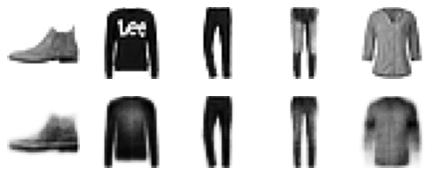

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae) 

#### (3) 可视化Fashion MNIST数据集
* 训练好栈式自动编码器之后，就可以用它给数据集降维了
* 利用自动编码器将数据集降维到一个合理的水平，然后使用另外一个降维算法做可视化

1. 使用栈式自动编码器的编码器将纬度降到30
2. 使用sklearn的t-SNE算法将维度降到2并做可视化

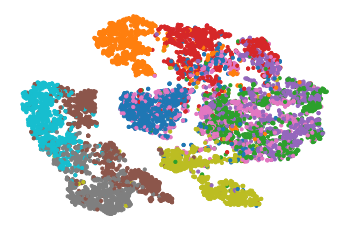

In [6]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed=stacked_encoder.predict(X_valid)
tsne=TSNE()
X_valid_2D=tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

# 对数据集作图：
plt.scatter(
    X_valid_2D[:,0], #指定 X 轴数据
    X_valid_2D[:,1], #指定 Y 轴数据
    c=y_valid, #指定散点的颜色
    s=10, #指定散点的大小
    cmap='tab10' #指定散点的颜色映射，会使用不同的颜色来区分散点的值
)
plt.axis("off")
plt.show()

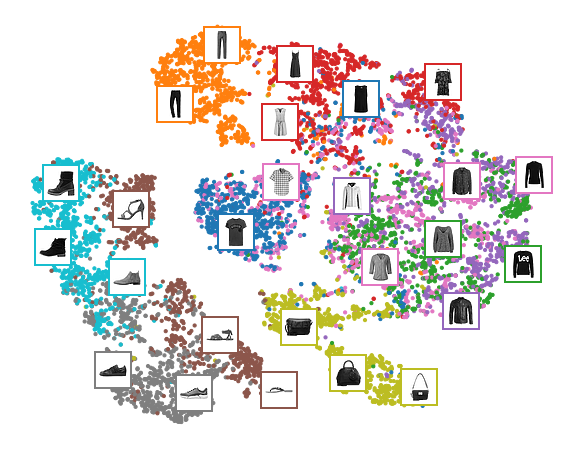

In [7]:
import matplotlib as mpl
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### 2.卷积自动编码器
* 卷积自动编码器降低输入的空间维度（即，高和宽），同时增加深度（即，特征映射的数量）
* 解码器的工作相反，即放大图片，压缩深度

In [8]:
#卷积自动编码器
conv_encoder=Sequential([
    Reshape([28,28,1],input_shape=[28,28]),
    Conv2D(16,kernel_size=3,padding='same',activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,kernel_size=3,padding='same',activation='selu'),
    MaxPool2D(pool_size=2),
    Conv2D(64,kernel_size=3,padding='same',activation='selu'),
    MaxPool2D(pool_size=2)
])

In [9]:
#卷积自动解码器
conv_decoder=Sequential([
    Conv2DTranspose(32,kernel_size=3,strides=2,padding='valid',activation='selu',input_shape=[3,3,64]),
    Conv2DTranspose(16,kernel_size=3,strides=2,padding='same',activation='selu'),
    Conv2DTranspose(1,kernel_size=3,strides=2,padding='same',activation='sigmoid'),
    Reshape([28,28])
])

conv_ae=Sequential([conv_encoder,conv_decoder])
conv_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


### 3.循环自动编码器
* 循环自动编码器中的编码器是一个“序列到向量”的 RNN，而解码器是“向量到序列”的 RNN

1. RepeatVector(n)：将输入重复n次
2. TimeDistributed(layer)：将一个层应用于输入的每个时间片，输入至少为 3D，且第一个维度应该是时间所表示的维度

如：考虑一个批量数为 32的样本，其中每个样本是 10 个 16 维向量的序列。则这个批量的输入尺寸为 (32, 10, 16)， input_shape 为 (10, 16)。

TimeDistributed层的作用就是把Dense层应用到这10个具体的16维向量上，对每一个向量进行了一次Dense操作。

#### 1.RepeatVector

In [10]:
model=Sequential()
model.add(Dense(10,input_dim=32))
model.add(RepeatVector(3))
model.add(Dense(16))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 10)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3, 16)             176       
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


#### 2.TimeDistributed

In [11]:
model=Sequential()
model.add(TimeDistributed(Dense(8),input_shape=(10,16)))
model.add(TimeDistributed(Dense(32)))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 8)             136       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 32)            288       
Total params: 424
Trainable params: 424
Non-trainable params: 0
_________________________________________________________________


#### 3.recurrent_ae

In [12]:
#循环自动编码器可以处理任意长度的序列，每个时间步有28个维度 [28,28]
#可以将 Fashion MNIST 的图片作为行序列来处理
recurrent_encoder=Sequential([
    LSTM(100,return_sequences=True,input_shape=[None,28]),
    LSTM(30)
])

#解码器第一层用的是RepeatVector，以保证在每个时间步将输入向量传给解码器
recurrent_decoder=Sequential([
    RepeatVector(28,input_shape=[30]),
    LSTM(100,return_sequences=True),
    TimeDistributed(Dense(28,activation='sigmoid'))
])

recurrent_ae=Sequential([recurrent_encoder,recurrent_decoder])
recurrent_ae.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 30)                67320     
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28)            55228     
Total params: 122,548
Trainable params: 122,548
Non-trainable params: 0
_________________________________________________________________


In [13]:
recurrent_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_1 (RepeatVecto (None, 28, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 100)           52400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 28, 28)            2828      
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


### 4.降噪自编码器
* 为其输入添加噪声，对其进行训练以恢复原始的无噪声输入
* Dropout或GaussianNoise层只在训练中起作用
1. 高斯噪声降噪自动编码器
2. 丢弃降噪自动编码器
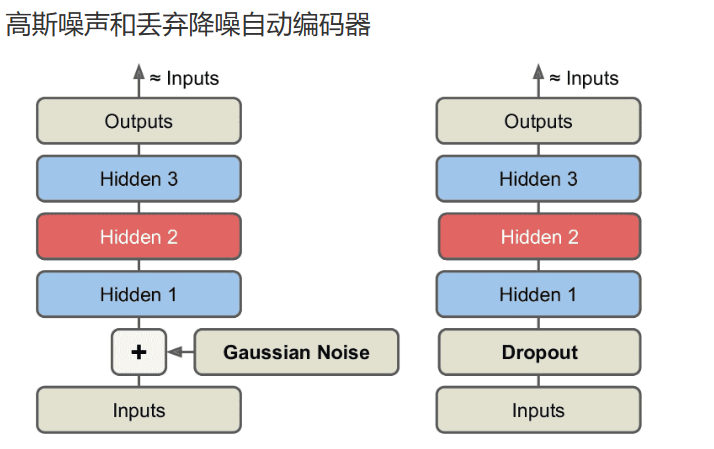

In [14]:
dropout_encoder=Sequential([
    Flatten(input_shape=[28,28]),
    Dropout(0.5),
    Dense(100,activation='selu'),
    Dense(30,activation='selu')
])

dropout_decoder=Sequential([
    Dense(100,activation='selu',input_shape=[30]),
    Dense(28*28,activation='sigmoid'),
    Reshape([28,28])
])

dropout_ae=Sequential([dropout_encoder,dropout_decoder])
dropout_ae.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_12 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [15]:
dropout_decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### 5.稀疏自动编码器
* 在神经网络中添加适当损失函数，从而让自动编码器减少编码层中活动神经元的数量
* 迫使自动编码器将每个输入表示为少量激活的组合

1.ActivityRegularization添加了ℓ1正则化: 使神经网络产生更多0值权重，从而容易产生稀疏矩阵

In [16]:
'''使用 sigmoid 激活函数，并给编码层的激活函数添加ℓ1正则化'''
sparse_l1_encoder=Sequential([
    Flatten(input_shape=[28,28]),
    Dense(100,activation='selu'),
    Dense(300,activation='sigmoid'),
    ActivityRegularization(l1=1e-3)
])

sparse_l1_decoder=Sequential([
    Dense(100,activation='selu',input_shape=[300]),
    Dense(28*28,activation='sigmoid'),
    Reshape([28,28])
])
sparse_l1_ae=Sequential([sparse_l1_encoder,sparse_l1_decoder])
sparse_l1_ae.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 300)               108800    
_________________________________________________________________
sequential_15 (Sequential)   (None, 28, 28)            109284    
Total params: 218,084
Trainable params: 218,084
Non-trainable params: 0
_________________________________________________________________


### 6.变分自动编码器（VAE）
* VAE要做变分贝叶斯推断，这是估计变微分推断的一种有效方式

#### 1.创建Fashion MNIST自动编码器
* 编码采样层，接收两个输入：mean(μ) 和log_var (γ)
* K.random_normal()完成正态分布随机采样
* 实现从平均值为 0 标准差为 1 的正态分布采样编码向量

In [3]:
#Keras后端引擎(backend)
#引用keras的后端以后，张量操作就可以通过统一的后端接口完成，而不关心具体执行这些操作的是Theano还是TensorFlow
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#### （1）创建编码器

In [8]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [13]:
variational_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 150)          117750      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          15100       dense_4[0][0]                    
____________________________________________________________________________________________

#### （2）创建解码器

In [10]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [12]:
variational_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_9 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 134,634
Trainable params: 134,634
Non-trainable params: 0
_________________________________________________________________


#### （3）创建变分自动编码器

In [33]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [34]:
variational_ae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
model_3 (Functional)         [(None, 10), (None, 10),  134870    
_________________________________________________________________
model_4 (Functional)         (None, 28, 28)            134634    
Total params: 269,504
Trainable params: 269,504
Non-trainable params: 0
_________________________________________________________________


#### （4）将潜在损失和重建损失累加

In [35]:
'''
使用"binary_crossentropy" 计算损失时，得到的是 784 个像素的平均值
VAE的重建损失是像素重建误差的和
计算的重建损失比真正的值小 784 倍
'''
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

#### （5）训练自动编码器

In [36]:
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/50


430/430 [==============================] - 4s 6ms/step - loss: 0.3879 - val_loss: 0.3553
Epoch 2/50
430/430 [==============================] - 4s 9ms/step - loss: 0.3423 - val_loss: 0.3384
Epoch 3/50
430/430 [==============================] - 4s 9ms/step - loss: 0.3323 - val_loss: 0.3298
Epoch 4/50
430/430 [==============================] - 4s 10ms/step - loss: 0.3272 - val_loss: 0.3269
Epoch 5/50
430/430 [==============================] - 4s 10ms/step - loss: 0.3242 - val_loss: 0.3235
Epoch 6/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3221 - val_loss: 0.3217
Epoch 7/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3205 - val_loss: 0.3251
Epoch 8/50
430/430 [==============================] - 5s 12ms/step - loss: 0.3193 - val_loss: 0.3196
Epoch 9/50
430/430 [==============================] - 4s 9ms/step - loss: 0.3182 - val_loss: 0.3201
Epoch 10/50
430/430 [==============================] - 9s 21ms/step - loss: 0.3173 - val_loss: 0.3195
Epo

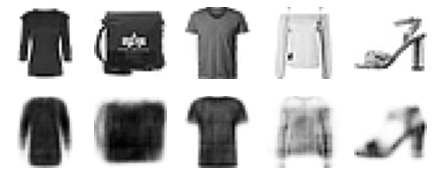

In [38]:
show_reconstructions(variational_ae)
plt.show()

### 2.生成Fashion MNIST图片
* 用VAE生成图片
* 从高斯分布随机采样编码
* 解码

In [55]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

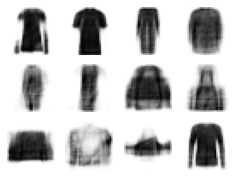

In [56]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

#### （2）语义插值

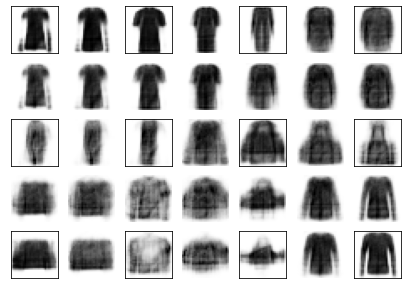

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

### VAE生成MNIST数据

#### （1）加载模块

In [73]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

#### （2）准备数据

In [74]:
def prepare(images,labels):
    images=images.astype('float32')/255
    n,w,h=images.shape
    return images.reshape((n,w*h)),to_categorical(labels)

train,test=mnist.load_data()
x_train,y_train=prepare(*train)
x_test,y_test=prepare(*test)
img_width,img_height=train[0].shape[1:]

#### （3）构造随机数

In [75]:
batch_size=250
latent_space_depth=2

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

#### （4）定义VAE网络

In [76]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels,))
    encoder_hidden = Dense(512, activation='relu')(pixels)
    
    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)

    def KL_loss(y_true,y_pred):
        return (0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true,y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

    def total_loss(y_true,y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)
    
    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_hidden = Dense(512, activation='relu')
    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')
    decoder_in = Input(shape=(latent_space_depth,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)
    
    hidden = decoder_hidden(z)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model(pixels, outputs)
    auto_encoder.compile(optimizer=Adam(learning_rate=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    return auto_encoder, decoder

In [77]:
auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 512)          401920      input_3[0][0]                    
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 2)            1026        dense_64[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 2)            1026        dense_64[0][0]                   
___________________________________________________________________________________________

#### （5）训练

In [78]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [79]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 72us/sample - loss: 214.1424 - KL_loss: 10.3848 - reconstruction_loss: 203.7576 - val_loss: 181.7238 - val_KL_loss: 5.4252 - val_reconstruction_loss: 176.2986
Epoch 2/100
60000/60000 [==============================] - 4s 63us/sample - loss: 175.5871 - KL_loss: 4.8386 - reconstruction_loss: 170.7486 - val_loss: 170.4665 - val_KL_loss: 4.7916 - val_reconstruction_loss: 165.6749
Epoch 3/100
60000/60000 [==============================] - 4s 65us/sample - loss: 168.3236 - KL_loss: 4.8300 - reconstruction_loss: 163.4935 - val_loss: 166.7196 - val_KL_loss: 4.8764 - val_reconstruction_loss: 161.8433
Epoch 4/100
60000/60000 [==============================] - 4s 66us/sample - loss: 165.6261 - KL_loss: 4.9543 - reconstruction_loss: 160.6718 - val_loss: 164.8094 - val_KL_loss: 4.9403 - val_reconstruction_loss: 159.8691
Epoch 5/100
60000/60000 [==============================] - 4s 65us/sa

#### （6）显示预测结果

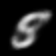

In [82]:
random_number = np.asarray([[np.random.normal() for _ in range(latent_space_depth)]])
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height)).resize((56, 56))

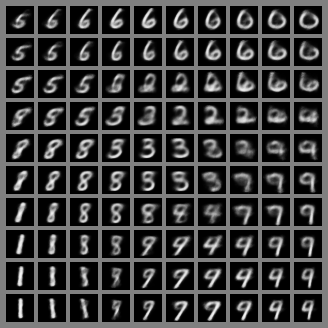

In [83]:
num_cells = 10
overview = PIL.Image.new('RGB', (num_cells * (img_width + 4) + 8, 
num_cells * (img_height + 4) + 8), (128, 128, 128))
vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[:, 0] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
        vec[:, 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview